<a href="https://colab.research.google.com/github/nathaniellamjohnson/CAISNews-Headlines-for-Sarcasm-Detection-Winter-Project/blob/main/CAISNews_Headlines_for_Sarcasm_Detection_Winter_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
# Check we're using GPU
import torch

# If there's a GPU available...
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [62]:
# Working code snippet for downloading kaggle data
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"nljnlj","key":"6276389842ffd79fb5a4843dba3bebc0"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [63]:
# If shows up, working

! kaggle datasets list

ref                                                             title                                         size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  -------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
ahsan81/hotel-reservations-classification-dataset               Hotel Reservations Dataset                   480KB  2023-01-04 12:50:31           1544         60  1.0              
thedevastator/global-fossil-co2-emissions-by-country-2002-2022  Emissions by Country, 2002-2022              621KB  2023-01-02 20:10:36            894         35  1.0              
die9origephit/fifa-world-cup-2022-complete-dataset              Fifa World Cup 2022: Complete Dataset          7KB  2022-12-18 22:51:11           5004        164  1.0              
rakkesharv/spotify-top-10000-streamed-songs                     Spotify Top 10000 Streamed Song

In [29]:
! kaggle datasets download -d rmisra/news-headlines-dataset-for-sarcasm-detection

  0% 0.00/3.30M [00:00<?, ?B/s]
100% 3.30M/3.30M [00:00<00:00, 216MB/s]


In [32]:
# Unpacks zip file using shutil into /data
import shutil 
shutil.unpack_archive("news-headlines-dataset-for-sarcasm-detection.zip", "/content/data")

In [41]:
! cd data
!pwd

/content


In [43]:
# Paths to Folders for Test & Train
! ls /content/data
path_1 = "/content/data/Sarcasm_Headlines_Dataset.json"
path_2 = "/content/data/Sarcasm_Headlines_Dataset_v2.json"

Sarcasm_Headlines_Dataset.json	Sarcasm_Headlines_Dataset_v2.json


In [49]:
# Read both jsons, convert to dataframes
import pandas as pd 

a = pd.read_json(path_1, lines=True)
b = pd.read_json(path_2, lines=True)
b.sample(10)

,is_sarcastic,headline,article_link
12240,0,7 super seeds with big health benefits,https://www.huffingtonpost.com/entry/7-super-s...
8922,1,kerry vows to raise wife's taxes,https://politics.theonion.com/kerry-vows-to-ra...
13066,1,bride and groom clearly have not kissed much,https://local.theonion.com/bride-and-groom-cle...
20911,0,hbo's martin luther king jr. film reveals his ...,https://www.huffingtonpost.com/entry/hbo-marti...
8031,1,documentary viewer can't wait to find out whic...,https://local.theonion.com/documentary-viewer-...
10128,1,defensive clinton campaign releases new 'who a...,https://politics.theonion.com/defensive-clinto...
23817,0,'the simpsons' duff beer will soon be a reality,https://www.huffingtonpost.com/entry/the-simps...
23402,0,phyllis schlafly and the kingmakers,https://www.huffingtonpost.com/entry/phyllis-s...
24335,1,hero publicist honored,https://entertainment.theonion.com/hero-public...
27242,1,single napkin accompanying takeout order presu...,https://local.theonion.com/single-napkin-accom...


In [51]:
# Create master dataframe by appending
df = a.append(b)
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [52]:
# Get the lists of sentences and their labels.
headlines = df.headline.values
labels = df.is_sarcastic.values

In [57]:
# Load Bert Tokenizer
! pip install transformers
import transformers
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 49.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 91.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 22.7 MB/s eta 0:00:00


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [65]:
# Print the original sentence.
print(' Original: ', headlines[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(headlines[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(headlines[0])))

 Original:  former versace store clerk sues over secret 'black code' for minority shoppers
Tokenized:  ['former', 'versa', '##ce', 'store', 'clerk', 'sue', '##s', 'over', 'secret', "'", 'black', 'code', "'", 'for', 'minority', 'shop', '##pers']
Token IDs:  [2280, 18601, 3401, 3573, 7805, 9790, 2015, 2058, 3595, 1005, 2304, 3642, 1005, 2005, 7162, 4497, 7347]


In [60]:
import os

In [71]:
if os.path.exists("/content/drive/MyDrive/CAIS_Sentiment140_Project/training.1600000.processed.noemoticon.csv"):
  input_ids = torch.load("/content/drive/MyDrive/CAIS_Sentiment140_Project/savedtensors/input_ids.pt")
  attention_masks = torch.load("/content/drive/MyDrive/CAIS_Sentiment140_Project/savedtensors/attention_masks.pt")
  labels = torch.load("/content/drive/MyDrive/CAIS_Sentiment140_Project/savedtensors/targets.pt")
else:
  input_ids = []
  attention_masks = []

  # For every sentence...
  for x in headlines:
      # `encode_plus` will:
      #   (1) Tokenize the sentence.
      #   (2) Prepend the `[CLS]` token to the start.
      #   (3) Append the `[SEP]` token to the end.
      #   (4) Map tokens to their IDs.
      #   (5) Pad or truncate the sentence to `max_length`
      #   (6) Create attention masks for [PAD] tokens.
      encoded_dict = tokenizer.encode_plus(
                          x,                      # Sentence to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = 140,           # Pad & truncate all sentences.
                          pad_to_max_length = True,          # Pad & truncate all sentences.
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt'     # Return pytorch tensors.
                    )
      
      # Add the encoded sentence to the list.    
      input_ids.append(encoded_dict['input_ids'])
      
      # And its attention mask (simply differentiates padding from non-padding).
      attention_masks.append(encoded_dict['attention_mask'])

  # Convert the lists into tensors.
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels)

  # Print sentence 0, now as a list of IDs.
  print('Original: ', headlines[0])
  print('Token IDs:', input_ids[0])

Original:  former versace store clerk sues over secret 'black code' for minority shoppers
Token IDs: tensor([  101,  2280, 18601,  3401,  3573,  7805,  9790,  2015,  2058,  3595,
         1005,  2304,  3642,  1005,  2005,  7162,  4497,  7347,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0

In [79]:
# Time to save the results

if os.path.exists("/content/data/savedtensors/inputids.csv"):
  print("No need to resave.")
else:
  newpath = '/content/data/savedtensors/' 
  if not os.path.exists(newpath):
      os.makedirs(newpath)

  torch.save(headlines, f = "/content/data/savedtensors/data.csv" )
  torch.save(input_ids, f = "/content/data/savedtensors/inputids.csv" )
  torch.save(attention_masks, f = "/content/data/savedtensors/attentionmasks.csv" )
  torch.save(labels, f = "/content/data/savedtensors/labels.csv" )

No need to resave.


In [100]:
#Test Train Val Split


from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset. 90-10 train-val split
dataset = TensorDataset(input_ids, attention_masks, labels)
train_size = int(0.90 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

49,795 training samples
5,533 validation samples


In [101]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [102]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = 2,   output_attentions = False, output_hidden_states = False, )

# Tell pytorch to run this model on the GPU.
model.cuda()

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [103]:
# Define the optimizer
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate
                  eps = 1e-8 # args.adam_epsilon
                )


/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [104]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [105]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [106]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [107]:
import random
import numpy as np

seed_val = 9487

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # 0 the gradients
        model.zero_grad() 

        # Forward pass, calculate logit predictions.
        # token_type_ids is the same as the "segment ids", which 
        # differentiates sentence 1 and 2 in 2-sentence tasks.       
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        loss = result.loss
        logits = result.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of  1,557.    Elapsed: 0:00:32.
  Batch    80  of  1,557.    Elapsed: 0:01:02.
  Batch   120  of  1,557.    Elapsed: 0:01:32.
  Batch   160  of  1,557.    Elapsed: 0:02:01.
  Batch   200  of  1,557.    Elapsed: 0:02:30.
  Batch   240  of  1,557.    Elapsed: 0:03:00.
  Batch   280  of  1,557.    Elapsed: 0:03:29.
  Batch   320  of  1,557.    Elapsed: 0:03:58.
  Batch   360  of  1,557.    Elapsed: 0:04:28.
  Batch   400  of  1,557.    Elapsed: 0:04:57.
  Batch   440  of  1,557.    Elapsed: 0:05:27.
  Batch   480  of  1,557.    Elapsed: 0:05:56.
  Batch   520  of  1,557.    Elapsed: 0:06:26.
  Batch   560  of  1,557.    Elapsed: 0:06:55.
  Batch   600  of  1,557.    Elapsed: 0:07:24.
  Batch   640  of  1,557.    Elapsed: 0:07:54.
  Batch   680  of  1,557.    Elapsed: 0:08:23.
  Batch   720  of  1,557.    Elapsed: 0:08:53.
  Batch   760  of  1,557.    Elapsed: 0:09:22.
  Batch   800  of  1,557.    Elapsed: 0:09:51.
  Batch   840  of

In [109]:
# Final Accuracy with more sig digits
print(avg_val_accuracy)

0.9929552023121387


In [111]:
# Display floats with two decimal places.
pd.set_option('precision', 6)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.193628,0.092275,0.968009,0:19:08,0:00:49
2,0.054422,0.048705,0.988439,0:19:06,0:00:49
3,0.015554,0.041709,0.992575,0:19:03,0:00:49
4,0.007791,0.038829,0.992955,0:19:03,0:00:49


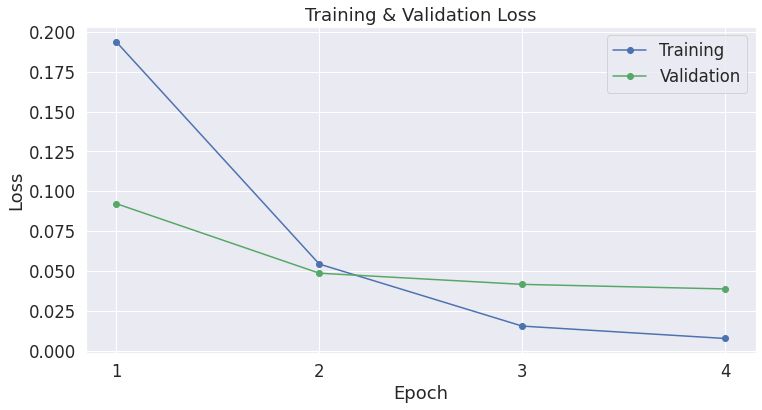

In [112]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [128]:
# Check if model works with actual headlines sourced from internet

# If label_0 is high, then the model predicts it to be not sarcastic
# If label_1 is high, then the model predicts it to be sarcastic

# Test Headlines 
# (Sarcastic or Not, Source, Link)
# Kamala Harris Pops By Office To Print Out Concert Tickets (Sarcastic, The Onion, https://www.theonion.com/kamala-harris-pops-by-office-to-print-out-concert-ticke-1849900809)
# Man Who Stopped Dieting Already Seeing Results (Sarcastic, The Onion, https://www.theonion.com/man-who-stopped-dieting-already-seeing-results-1819577551)
# Katie Porter Uses Whiteboard To Explain To Dianne Feinstein Why This Her Office Now (Sarcastic, The Onion, https://www.theonion.com/katie-porter-uses-whiteboard-to-explain-to-dianne-feins-1849975873)
# Woman Experiencing “Catholic Guilt” Just Awful Human Being (Sarcastic, The Sack of Troy, https://www.sackoftroy.com/2023/01/03/woman-experiencing-catholic-guilt-just-awful-human-being/)
# Kevin McCarthy Fills Rejection Punch Card, Earns Free Frosty (Sarcastic, The Sack of Troy, https://www.sackoftroy.com/2023/01/09/kevin-mccarthy-fills-rejection-punch-card-earns-free-frosty/)
# Western Tanks Appear Headed to Ukraine, Breaking Another Taboo (Not Sarcastic, New York Times, https://www.nytimes.com/2023/01/12/world/europe/ukraine-western-tanks.html)
# Is Stephanie Hsu the ‘Dark Horse’ of Award Season? (Not Sarcastic, New York Times, https://www.nytimes.com/2023/01/11/movies/stephanie-hsu-everything-everywhere-all-at-once.html)
# Garland Appoints Special Counsel to Investigate Handling of Biden Documents (Not Sarcastic, New York Times, https://www.nytimes.com/2023/01/12/us/politics/biden-documents.html)
# At least 7 dead as severe winds, tornadoes hammer US South (Not Sarcastic, AP News, https://apnews.com/article/tornadoes-disaster-planning-and-response-selma-alabama-climate-environment-7f9d8545a4ba04e3d398579b052d36dd?utm_source=homepage&utm_medium=TopNews&utm_campaign=position_01)
# China’s trade surplus swells to $877.6B as exports grow (Not Sarcastic, AP News, https://apnews.com/article/inflation-shanghai-business-0c0f7946bc3c08db1df13eb78911f4aa?utm_source=homepage&utm_medium=TopNews&utm_campaign=position_08)

from transformers import TextClassificationPipeline

c = ["Kamala Harris Pops By Office To Print Out Concert Tickets", "Man Who Stopped Dieting Already Seeing Results", 
"Katie Porter Uses Whiteboard To Explain To Dianne Feinstein Why This Her Office Now",
"Woman Experiencing “Catholic Guilt” Just Awful Human Being",
"Kevin McCarthy Fills Rejection Punch Card, Earns Free Frosty",
"Western Tanks Appear Headed to Ukraine, Breaking Another Taboo", 
"Is Stephanie Hsu the ‘Dark Horse’ of Award Season?",
"Garland Appoints Special Counsel to Investigate Handling of Biden Documents",
"At least 7 dead as severe winds, tornadoes hammer US South",
"China’s trade surplus swells to $877.6B as exports grow"]

pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=True, device = 0)

for x in c:
  print(x)
  print(pipe(x))




Kamala Harris Pops By Office To Print Out Concert Tickets
[[{'label': 'LABEL_0', 'score': 4.602668559527956e-05}, {'label': 'LABEL_1', 'score': 0.9999539852142334}]]
Man Who Stopped Dieting Already Seeing Results
[[{'label': 'LABEL_0', 'score': 2.097691503877286e-05}, {'label': 'LABEL_1', 'score': 0.9999790191650391}]]
Katie Porter Uses Whiteboard To Explain To Dianne Feinstein Why This Her Office Now
[[{'label': 'LABEL_0', 'score': 0.00010519266652408987}, {'label': 'LABEL_1', 'score': 0.9998947381973267}]]
Woman Experiencing “Catholic Guilt” Just Awful Human Being
[[{'label': 'LABEL_0', 'score': 2.1328063667169772e-05}, {'label': 'LABEL_1', 'score': 0.9999786615371704}]]
Kevin McCarthy Fills Rejection Punch Card, Earns Free Frosty
[[{'label': 'LABEL_0', 'score': 0.031183570623397827}, {'label': 'LABEL_1', 'score': 0.9688164591789246}]]
Western Tanks Appear Headed to Ukraine, Breaking Another Taboo
[[{'label': 'LABEL_0', 'score': 0.999901294708252}, {'label': 'LABEL_1', 'score': 9.869

Based on this extremely limited test, it seems that this model accurately predicts the "sarcasticness" of the news headlines given to it. This is limited by a few key factors - 
*   Data limitations - The model is trained on generally left-leaning news headlines. For example, in the code cell below, the first headline comes from Infowars, a right-biased news source, is incorrectly identified as sarcastic. However, the next headline comes from FOX news and is correctly identified as non-sarcastic. This needs to be looked in to more to ensure that the data collection sources and methods have not restricted the model to mispredict sources unlike the training data. (By the way I don't support or watch Infowars, but it's an interesting conversation to have nonetheless)



In [130]:
print ( pipe("COVID Shots Are Toxic Depopulation Weapon Being Calibrated For Mass Culling"))
print (pipe("Joe Rogan puts leftist mega-donor on blast"))


[[{'label': 'LABEL_0', 'score': 0.00015662562509533018}, {'label': 'LABEL_1', 'score': 0.9998433589935303}]]
[[{'label': 'LABEL_0', 'score': 0.9926514029502869}, {'label': 'LABEL_1', 'score': 0.007348587736487389}]]


/usr/local/lib/python3.8/dist-packages/transformers/pipelines/base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
